In [1]:
import numpy as np
from FlagRepp import FlagRepp
from matplotlib import pyplot as plt
from FlagRep0 import chordal_distance

import pandas as pd

import seaborn as sns

from sklearn.metrics.pairwise import paired_cosine_distances, paired_euclidean_distances

from sklearn.decomposition import PCA

import itertools

from sklearn.manifold import MDS


In [2]:
n_pts = 60
n_clusters = 3

np.random.seed(42)

n = 10
col_ids = [20,20]
p = np.sum(col_ids)
hidden_flag_type = [2,4]
hidden_ms = [2,2]
noise_exps = range(1,1000,50)
distributions = ['Normal', 'Exponential', 'Uniform']

In [3]:
n_k = hidden_flag_type[-1]

centers = []
for _ in range(n_clusters):
    center = np.linalg.qr(np.random.randn(n, n_k))[0][:,:n_k]
    centers.append(center)


In [4]:
Ds = []
snr = []
labels = []
for class_num, center in enumerate(centers):
    for _ in range(n_pts//n_clusters):
        D_true = []
        for i in range(len(hidden_flag_type)): 
            cols = col_ids[i]
            n_i = hidden_flag_type[i]
            D_true_i = center[:,:n_i]@np.random.normal(size= (n_i, cols))
            D_true.append(D_true_i)
        D_true = np.hstack(D_true)
        epsilon = np.random.normal(scale = .95, size=(n,p))
        Ds.append(D_true+epsilon)
        labels.append(class_num)
        snr.append(10*np.log10(np.linalg.trace(D_true@D_true.T)/np.linalg.trace(epsilon@epsilon.T)))

mean_snr = np.mean(snr)
print(mean_snr)

-4.7941690048117875


In [5]:


flags = {}
flags['SVD'] = []
flags['FlagRep'] = []
for D in Ds:
    my_flag_rep = FlagRepp(Aset = [np.arange(col_ids[0]),np.arange(p)], solver = 'svd', flag_type=[2,4])
    flagrep_X, flagrep_R = my_flag_rep.fit_transform(D)

    U = np.linalg.svd(D)[0][:,:4]            
    svd_errs = []
    col_orderings = []
    for comb in itertools.combinations([0,1,2,3], 2):
        my_flag_rep = FlagRepp(Aset = [np.arange(col_ids[0]),np.arange(p)], flag_type=[2,4])
        id1 = np.array(list(set([0,1,2,3]).difference(set(list(comb)))))
        col_ordering = np.hstack([id1,np.array(comb)])
        svd_errs.append(my_flag_rep.objective_value(U[:,col_ordering],D))
        col_orderings.append(col_ordering)
    best_idx = np.argmin(svd_errs)
    err_svd = svd_errs[best_idx]
    svd_X = U[:,col_orderings[best_idx]]
    

    flags['SVD'].append(svd_X)
    flags['FlagRep'].append(flagrep_X)

flags['Euclidean'] = [D.flatten() for D in Ds]

In [6]:
flags.keys()

dict_keys(['SVD', 'FlagRep', 'Euclidean'])

In [7]:
def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

Bs = make_Bs(hidden_flag_type)

dist_mats = {}
dist_mats['SVD'] = np.zeros((n_pts,n_pts))
dist_mats['FlagRep'] = np.zeros((n_pts,n_pts))
dist_mats['Euclidean'] = np.zeros((n_pts,n_pts))
for method_name in ['Euclidean', 'SVD', 'FlagRep']:
    for i in range(n_pts):
        for j in range(i+1,n_pts):
            x = flags[method_name][i]
            y = flags[method_name][j]
            if method_name == 'Euclidean':
                dist = np.linalg.norm(x-y)
            else:
                dist = chordal_distance(x, y, Bs, Bs, manifold = 'Flag')
            dist_mats[method_name][i,j] = dist
            dist_mats[method_name][j,i] = dist

In [8]:
Ds_reduced = {}


for method_name in ['Euclidean', 'SVD','FlagRep']:
    my_mds = MDS(dissimilarity = 'precomputed')
    Ds_reduced[method_name] = my_mds.fit_transform(dist_mats[method_name])



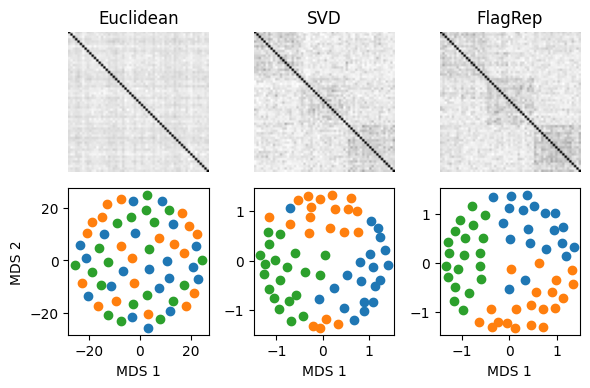

In [9]:
fig, ax = plt.subplots(2,3, figsize = (6,4))
for i, method_name in enumerate(['Euclidean', 'SVD', 'FlagRep']):
    ax[0,i].imshow(dist_mats[method_name], cmap = 'grey')
    ax[0,i].set_title(method_name)
    ax[0,i].axis('off')
    for l in np.unique(labels):
        idx = np.where(labels == l)[0]
        ax[1,i].scatter(Ds_reduced[method_name][idx,0], Ds_reduced[method_name][idx,1])
        ax[1,i].set_xlabel('MDS 1')
ax[1,0].set_ylabel('MDS 2')
plt.tight_layout()
plt.savefig('../results/synthetic_clustering_dr.pdf', bbox_inches = 'tight')

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def evaluate_knn_with_distances(distance_matrix, y, k_values):
    accuracies = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        
        # Fit the model using the training distance matrix and labels
        knn.fit(distance_matrix, y)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(distance_matrix)
        
        # Calculate accuracy
        accuracy = accuracy_score(y, y_pred)
        # print(f"k={k}, Accuracy: {accuracy:.4f}")
        accuracies.append(accuracy)
    
    return accuracies

Accuracy [0.9666666666666667, 0.95, 0.9833333333333333, 0.9666666666666667, 1.0]
Accuracy [1.0, 0.9833333333333333, 1.0, 1.0, 0.9833333333333333]
Accuracy [0.5666666666666667, 0.55, 0.5166666666666667, 0.5333333333333333, 0.4666666666666667]


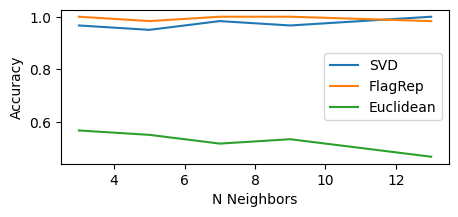

In [11]:
plt.figure(figsize = (5,2))
for i, method_name in enumerate(dist_mats.keys()):
    accuracies = evaluate_knn_with_distances(dist_mats[method_name], labels, [3,5,7,9,13])
    plt.plot([3,5,7,9,13], accuracies, label = method_name)
    print(f'Accuracy {accuracies}')
plt.xlabel('N Neighbors')
plt.ylabel('Accuracy')
plt.legend()